# Dust Detection from Remote Sensing Images
In this notebook input images are used from MODIS Terra satellite from NASA. Here one sample .hdf file is used for input.
There is one data folder where the .hdf file is located. That file is downloaded from NASA LAADS DAAC.

##### All the Necessary packages and libraries are loaded

In [2]:
from scipy.signal import cspline2d

import imageio as img
# import cv2
from PIL import Image
from skimage import io


import matplotlib.pyplot as plt

from satpy import Scene, MultiScene, available_readers, available_writers, find_files_and_readers
# from satpy.readers import modis_l1b, modis_l2
# from satpy.writers import get_enhanced_image
# from satpy.composites import GenericCompositor

import numpy as np
import pandas as pd
from pyresample import geometry

import os
import warnings

import matplotlib.pyplot as plt
# import earthpy as et
# import earthpy.plot as ep

# from datetime import datetime

# from skimage.io import imread, imshow, concatenate_images
# from skimage.transform import resize
# from sklearn.model_selection import train_test_split

# from keras.models import Model, load_model
# from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
# from keras.layers.convolutional import Conv2D, Conv2DTranspose
# from keras.layers.pooling import MaxPooling2D
# from keras.layers.merge import concatenate
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from keras.preprocessing.image import img_to_array, load_img

# import tensorflow as tf
# import statements
import torch
import torch.nn as nn
from torch.utils import data
from torchvision import datasets, transforms, models
import argparse
from tqdm import tqdm
import time
import torchvision

from tensorboardX import SummaryWriter

# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix, compute_accuracy
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import UnNormalize
from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler

# from utils import load_checkpoint, save_checkpoint, ensure_dir
# from model import MyModel

## Module 1: Remote Sensing MODIS Data
##### Checking the directory to find the location of data

In [32]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
LAMBDA = 0.01
BATCH_SIZE = 128
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

In [33]:
class DustDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        # print(img_path)
        if self.transform:
            image = self.transform(image)

        return (image, y_label)

Image batch dimensions: torch.Size([32, 3, 128, 128])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Fold 1
Epoch: 001/010 | Batch 0000/0016 | Loss: 0.6879
Epoch: 001/010 | Train: 79.06% | Validation: 77.78%
Time elapsed: 0.52 min
Epoch: 002/010 | Batch 0000/0016 | Loss: 0.4719
Epoch: 002/010 | Train: 79.06% | Validation: 77.78%
Time elapsed: 1.03 min
Epoch: 003/010 | Batch 0000/0016 | Loss: 0.2704
Epoch: 003/010 | Train: 79.06% | Validation: 77.78%
Time elapsed: 1.55 min
Epoch: 004/010 | Batch 0000/0016 | Loss: 0.3602
Epoch: 004/010 | Train: 79.06% | Validation: 77.78%
Time elapsed: 2.07 min
Epoch: 005/010 | Batch 0000/0016 | Loss: 0.4034
Epoch: 005/010 | Train: 79.06% | Validation: 77.78%
Time elapsed: 2.60 min
Epoch: 006/010 | Batch 0000/0016 | Loss: 0.3185
Epoch: 006/010 | Train: 79.06% | Validation: 77.78%
Time elapsed: 3.12 min
Epoch: 007/010 | Batch 0000/0016 | Loss: 0.2361
Epoch: 007/010 | Train: 89.63% | Validation:

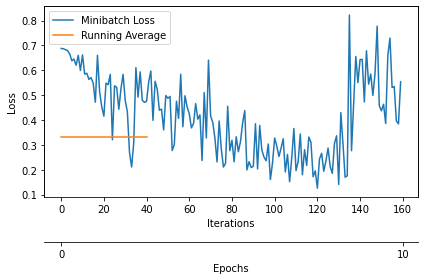

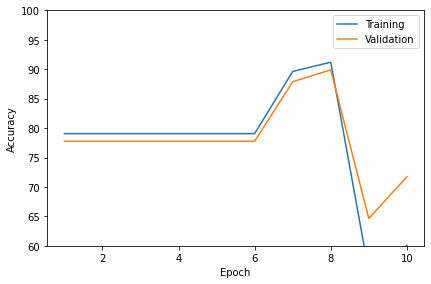

Fold 2
Epoch: 001/010 | Batch 0000/0016 | Loss: 0.6917
Epoch: 001/010 | Train: 79.65% | Validation: 77.78%
Time elapsed: 0.51 min
Epoch: 002/010 | Batch 0000/0016 | Loss: 0.5773
Epoch: 002/010 | Train: 79.65% | Validation: 77.78%
Time elapsed: 1.02 min
Epoch: 003/010 | Batch 0000/0016 | Loss: 0.3952
Epoch: 003/010 | Train: 79.65% | Validation: 77.78%
Time elapsed: 1.53 min
Epoch: 004/010 | Batch 0000/0016 | Loss: 0.3597
Epoch: 004/010 | Train: 79.65% | Validation: 77.78%
Time elapsed: 2.04 min
Epoch: 005/010 | Batch 0000/0016 | Loss: 0.3296
Epoch: 005/010 | Train: 79.65% | Validation: 77.78%
Time elapsed: 2.55 min
Epoch: 006/010 | Batch 0000/0016 | Loss: 0.4023
Epoch: 006/010 | Train: 79.65% | Validation: 77.78%
Time elapsed: 3.06 min
Epoch: 007/010 | Batch 0000/0016 | Loss: 0.4771
Epoch: 007/010 | Train: 87.87% | Validation: 85.86%
Time elapsed: 3.57 min
Epoch: 008/010 | Batch 0000/0016 | Loss: 0.2690
Epoch: 008/010 | Train: 91.98% | Validation: 89.90%
Time elapsed: 4.08 min
Epoch: 00

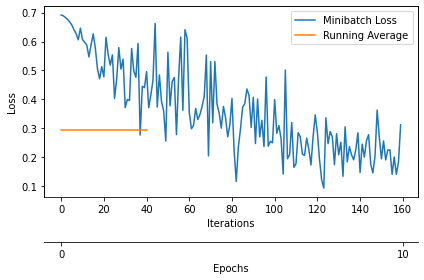

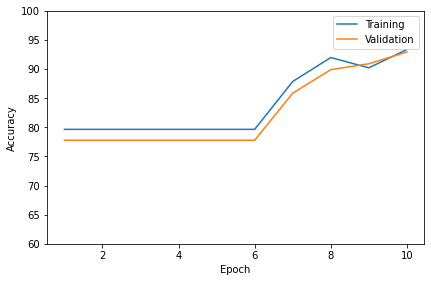

Fold 3
Epoch: 001/010 | Batch 0000/0016 | Loss: 0.6840
Epoch: 001/010 | Train: 79.84% | Validation: 77.78%
Time elapsed: 0.51 min
Epoch: 002/010 | Batch 0000/0016 | Loss: 0.5727
Epoch: 002/010 | Train: 79.84% | Validation: 77.78%
Time elapsed: 1.02 min
Epoch: 003/010 | Batch 0000/0016 | Loss: 0.4444
Epoch: 003/010 | Train: 79.84% | Validation: 77.78%
Time elapsed: 1.54 min
Epoch: 004/010 | Batch 0000/0016 | Loss: 0.4966
Epoch: 004/010 | Train: 79.84% | Validation: 77.78%
Time elapsed: 2.05 min
Epoch: 005/010 | Batch 0000/0016 | Loss: 0.2866
Epoch: 005/010 | Train: 79.84% | Validation: 77.78%
Time elapsed: 2.56 min
Epoch: 006/010 | Batch 0000/0016 | Loss: 0.4552
Epoch: 006/010 | Train: 79.84% | Validation: 77.78%
Time elapsed: 3.07 min
Epoch: 007/010 | Batch 0000/0016 | Loss: 0.3286
Epoch: 007/010 | Train: 89.24% | Validation: 89.90%
Time elapsed: 3.58 min
Epoch: 008/010 | Batch 0000/0016 | Loss: 0.1581
Epoch: 008/010 | Train: 91.39% | Validation: 88.89%
Time elapsed: 4.09 min
Epoch: 00

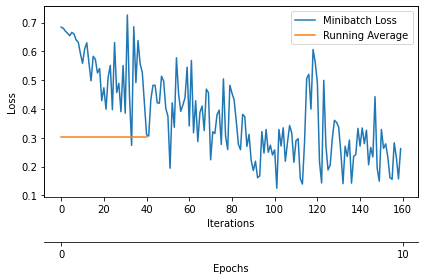

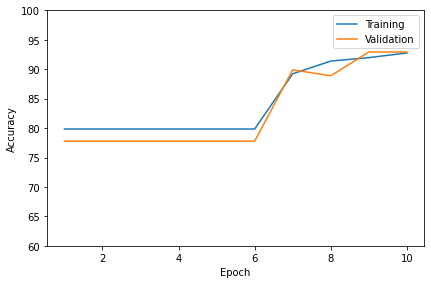

Fold 4
Epoch: 001/010 | Batch 0000/0016 | Loss: 0.6958
Epoch: 001/010 | Train: 81.41% | Validation: 77.78%
Time elapsed: 0.51 min
Epoch: 002/010 | Batch 0000/0016 | Loss: 0.4699
Epoch: 002/010 | Train: 81.41% | Validation: 77.78%
Time elapsed: 1.03 min
Epoch: 003/010 | Batch 0000/0016 | Loss: 0.4915
Epoch: 003/010 | Train: 81.41% | Validation: 77.78%
Time elapsed: 1.54 min
Epoch: 004/010 | Batch 0000/0016 | Loss: 0.3850
Epoch: 004/010 | Train: 81.41% | Validation: 77.78%
Time elapsed: 2.05 min
Epoch: 005/010 | Batch 0000/0016 | Loss: 0.3775
Epoch: 005/010 | Train: 81.41% | Validation: 77.78%
Time elapsed: 2.56 min
Epoch: 006/010 | Batch 0000/0016 | Loss: 0.3794
Epoch: 006/010 | Train: 81.41% | Validation: 77.78%
Time elapsed: 3.07 min
Epoch: 007/010 | Batch 0000/0016 | Loss: 0.1690
Epoch: 007/010 | Train: 81.41% | Validation: 77.78%
Time elapsed: 3.59 min
Epoch: 008/010 | Batch 0000/0016 | Loss: 0.2355
Epoch: 008/010 | Train: 87.87% | Validation: 83.84%
Time elapsed: 4.10 min
Epoch: 00

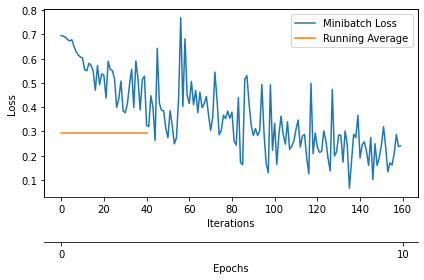

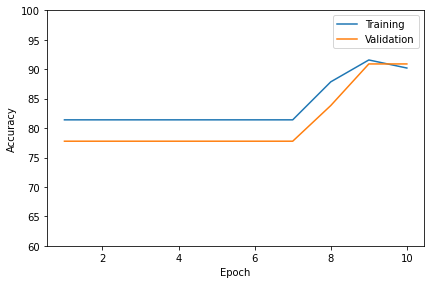

Fold 5
Epoch: 001/010 | Batch 0000/0016 | Loss: 0.6911
Epoch: 001/010 | Train: 79.88% | Validation: 77.78%
Time elapsed: 0.51 min
Epoch: 002/010 | Batch 0000/0016 | Loss: 0.5974
Epoch: 002/010 | Train: 79.88% | Validation: 77.78%
Time elapsed: 1.03 min
Epoch: 003/010 | Batch 0000/0016 | Loss: 0.3160
Epoch: 003/010 | Train: 79.88% | Validation: 77.78%
Time elapsed: 1.55 min
Epoch: 004/010 | Batch 0000/0016 | Loss: 0.4149
Epoch: 004/010 | Train: 79.88% | Validation: 77.78%
Time elapsed: 2.06 min
Epoch: 005/010 | Batch 0000/0016 | Loss: 0.3529
Epoch: 005/010 | Train: 79.88% | Validation: 77.78%
Time elapsed: 2.58 min
Epoch: 006/010 | Batch 0000/0016 | Loss: 0.3252
Epoch: 006/010 | Train: 79.88% | Validation: 77.78%
Time elapsed: 3.09 min
Epoch: 007/010 | Batch 0000/0016 | Loss: 0.3693
Epoch: 007/010 | Train: 90.62% | Validation: 86.87%
Time elapsed: 3.61 min
Epoch: 008/010 | Batch 0000/0016 | Loss: 0.1997
Epoch: 008/010 | Train: 85.16% | Validation: 82.83%
Time elapsed: 4.13 min
Epoch: 00

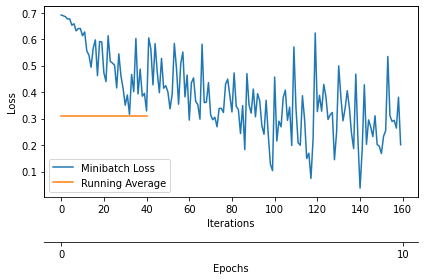

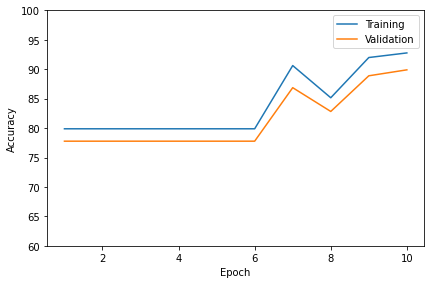

In [21]:
from sklearn.model_selection import StratifiedKFold, KFold

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_transforms = torchvision.transforms.Compose([       
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cv = KFold(n_splits=5, random_state=123, shuffle=True)

# Load Data
dataset = DustDataset(
    csv_file="dataset.csv",
    root_dir="dataset/",
    transform=train_transforms,
)


train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [440, 99, 100])
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)

kv_dataset = ConcatDataset([train_set, valid_set, test_set])

# Checking the dataset
for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break
    
for fold, (train_idx, val_idx) in enumerate(cv.split(kv_dataset)):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)
    
    model = AlexNetDust(num_classes=2)

    model = model.to(DEVICE)

    optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01, weight_decay=LAMBDA)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                           factor=0.1,
                                                           mode='max',
                                                           verbose=True)

    minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
        model=model,
        num_epochs=NUM_EPOCHS,
        train_loader=train_loader,
        valid_loader=valid_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        device=DEVICE,
        scheduler=scheduler,
        scheduler_on='valid_acc',
        logging_interval=100)

    plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                       num_epochs=NUM_EPOCHS,
                       iter_per_epoch=len(train_loader),
                       results_dir=None,
                       averaging_iterations=200)
    plt.show()

    plot_accuracy(train_acc_list=train_acc_list,
                  valid_acc_list=valid_acc_list,
                  results_dir=None)
    plt.ylim([60, 100])
    plt.show()
    

#     history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

#     for epoch in range(num_epochs):
#         train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
#         test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

#         train_loss = train_loss / len(train_loader.sampler)
#         train_acc = train_correct / len(train_loader.sampler) * 100
#         test_loss = test_loss / len(test_loader.sampler)
#         test_acc = test_correct / len(test_loader.sampler) * 100

#         print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
#                                                                                                              num_epochs,
#                                                                                                              train_loss,
#                                                                                                              test_loss,
#                                                                                                              train_acc,
#                                                                                                              test_acc))
#         history['train_loss'].append(train_loss)
#         history['test_loss'].append(test_loss)
#         history['train_acc'].append(train_acc)
#         history['test_acc'].append(test_acc)

#     foldperf['fold{}'.format(fold+1)] = history

In [26]:
class AlexNetDust(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        return logits

Epoch: 001/020 | Batch 0000/0005 | Loss: 1.6086
Epoch: 001/020 | Train: 38.67% | Validation: 32.35%
Time elapsed: 0.55 min
Epoch: 002/020 | Batch 0000/0005 | Loss: 1.6018
Epoch: 002/020 | Train: 38.67% | Validation: 32.35%
Time elapsed: 1.09 min
Epoch: 003/020 | Batch 0000/0005 | Loss: 1.5727
Epoch: 003/020 | Train: 38.67% | Validation: 32.35%
Time elapsed: 1.64 min
Epoch: 004/020 | Batch 0000/0005 | Loss: 1.5526
Epoch: 004/020 | Train: 38.67% | Validation: 32.35%
Time elapsed: 2.18 min
Epoch: 005/020 | Batch 0000/0005 | Loss: 1.5328
Epoch: 005/020 | Train: 38.67% | Validation: 32.35%
Time elapsed: 2.72 min
Epoch: 006/020 | Batch 0000/0005 | Loss: 1.5181
Epoch: 006/020 | Train: 38.67% | Validation: 32.35%
Time elapsed: 3.27 min
Epoch: 007/020 | Batch 0000/0005 | Loss: 1.5003
Epoch: 007/020 | Train: 38.67% | Validation: 32.35%
Time elapsed: 3.82 min
Epoch: 008/020 | Batch 0000/0005 | Loss: 1.5444
Epoch: 008/020 | Train: 38.67% | Validation: 32.35%
Time elapsed: 4.36 min
Epoch: 009/020 |

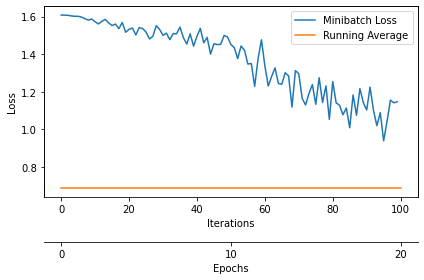

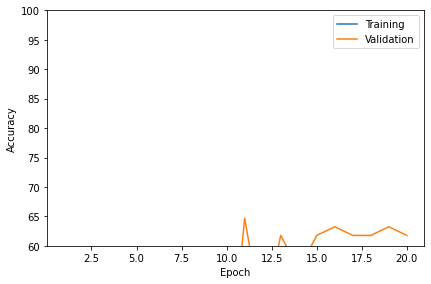

In [29]:
model = AlexNetDust(num_classes=5)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

In [34]:
##########################
### FINAL DUST DATASET
##########################

# resize_transform = torchvision.transforms.Compose(
#     [torchvision.transforms.Resize((32, 32)),
#      torchvision.transforms.ToTensor(),
#      torchvision.transforms.Normalize((0.5,), (0.5,))])

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_transforms = torchvision.transforms.Compose([       
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load Data
dataset = DustDataset(
    csv_file="dataset.csv",
    root_dir="dataset/",
    transform=train_transforms,
)

train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [600, 68, 100])



train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([128, 3, 128, 128])
Image label dimensions: torch.Size([128])
Class labels of 10 examples: tensor([1, 1, 0, 1, 1, 0, 2, 2, 0, 0])


In [17]:
##########################
### MODEL
##########################


class VGG16(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        
        self.block_1 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=64,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_2 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=128,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_3 = torch.nn.Sequential(        
                torch.nn.Conv2d(in_channels=128,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
          
        self.block_4 = torch.nn.Sequential(   
                torch.nn.Conv2d(in_channels=256,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_5 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),    
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))             
        )
            
        height, width = 3, 3 ## you may want to change that depending on the input image size
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512*height*width, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, num_classes),
        )
            
        for m in self.modules():
            if isinstance(m, torch.torch.nn.Conv2d) or isinstance(m, torch.torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()
                    
        self.avgpool = torch.nn.AdaptiveAvgPool2d((height, width))
        
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten
        
        logits = self.classifier(x)
        #probas = F.softmax(logits, dim=1)

        return logits

Epoch: 001/010 | Batch 0000/0014 | Loss: 0.6378
Epoch: 001/010 | Train: 78.18% | Validation: 85.86%
Time elapsed: 8.25 min
Epoch: 002/010 | Batch 0000/0014 | Loss: 0.4150
Epoch: 002/010 | Train: 83.41% | Validation: 91.92%
Time elapsed: 16.49 min
Epoch: 003/010 | Batch 0000/0014 | Loss: 0.3507
Epoch: 003/010 | Train: 69.09% | Validation: 70.71%
Time elapsed: 24.68 min
Epoch: 004/010 | Batch 0000/0014 | Loss: 0.3863
Epoch: 004/010 | Train: 78.18% | Validation: 85.86%
Time elapsed: 112.59 min
Epoch: 005/010 | Batch 0000/0014 | Loss: 0.6537
Epoch: 005/010 | Train: 78.18% | Validation: 85.86%
Time elapsed: 120.77 min
Epoch: 006/010 | Batch 0000/0014 | Loss: 0.4774
Epoch: 006/010 | Train: 78.18% | Validation: 85.86%
Time elapsed: 278.05 min
Epoch: 007/010 | Batch 0000/0014 | Loss: 0.4025
Epoch: 007/010 | Train: 78.18% | Validation: 85.86%
Time elapsed: 506.28 min
Epoch: 008/010 | Batch 0000/0014 | Loss: 0.2907
Epoch: 008/010 | Train: 82.27% | Validation: 90.91%
Time elapsed: 545.85 min
Epoc

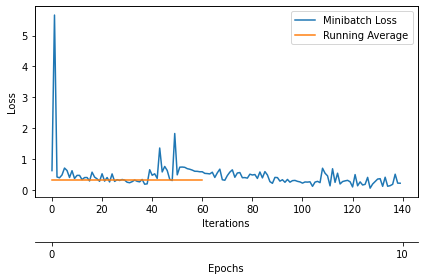

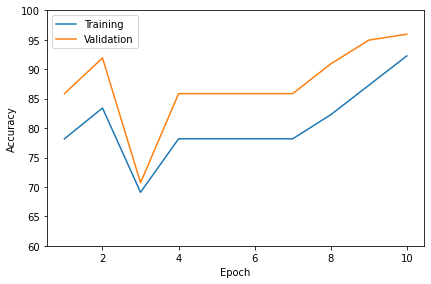

In [24]:
model = VGG16(num_classes=2)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

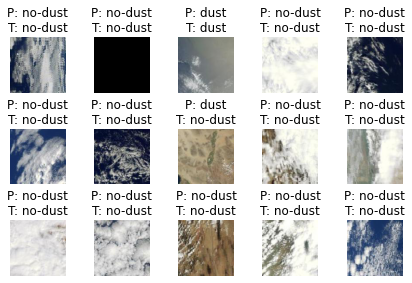

In [26]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {
              0: 'no-dust',
              1: 'dust'
            }

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

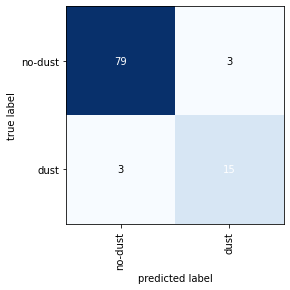

In [27]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

In [35]:
##########################
# RESNET34
##########################

# Code taken & adjusted from: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(torch.nn.Module):
    expansion: int = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(torch.nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion=4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = torch.nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(torch.nn.Module):

    def __init__(self, block, layers, num_classes, zero_init_residual=False, groups=1,
                 width_per_group=64, replace_stride_with_dilation=None, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = torch.nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                                     bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (torch.nn.BatchNorm2d, torch.nn.GroupNorm)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    torch.nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    torch.nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks,
                    stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



Epoch: 001/050 | Batch 0000/0005 | Loss: 1.6692
Epoch: 001/050 | Train: 35.67% | Validation: 38.24%
Time elapsed: 2.67 min
Epoch: 002/050 | Batch 0000/0005 | Loss: 15.0971
Epoch: 002/050 | Train: 25.50% | Validation: 26.47%
Time elapsed: 5.36 min
Epoch: 003/050 | Batch 0000/0005 | Loss: 3.4729
Epoch: 003/050 | Train: 25.50% | Validation: 26.47%
Time elapsed: 8.04 min
Epoch: 004/050 | Batch 0000/0005 | Loss: 20.1399
Epoch: 004/050 | Train: 25.50% | Validation: 26.47%
Time elapsed: 10.72 min
Epoch: 005/050 | Batch 0000/0005 | Loss: 1.1650
Epoch: 005/050 | Train: 25.50% | Validation: 26.47%
Time elapsed: 13.39 min
Epoch: 006/050 | Batch 0000/0005 | Loss: 0.9798
Epoch: 006/050 | Train: 40.00% | Validation: 38.24%
Time elapsed: 16.08 min
Epoch: 007/050 | Batch 0000/0005 | Loss: 0.8244
Epoch: 007/050 | Train: 58.50% | Validation: 52.94%
Time elapsed: 18.76 min
Epoch: 008/050 | Batch 0000/0005 | Loss: 0.9361
Epoch: 008/050 | Train: 65.83% | Validation: 61.76%
Time elapsed: 21.44 min
Epoch: 00

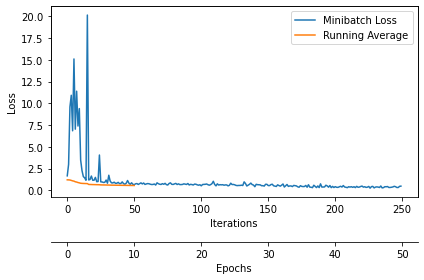

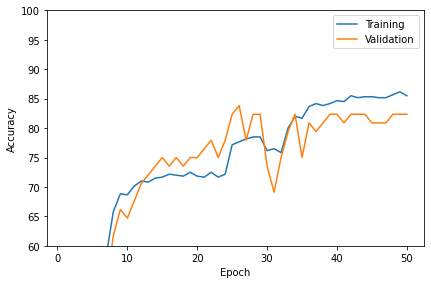

In [36]:
model = ResNet(BasicBlock, layers=[3, 4, 6, 3], num_classes=5) # ResNet34

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()


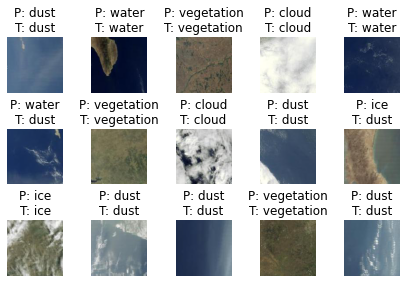

In [39]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {
              0: 'cloud',
              1: 'dust', 
              2: 'ice', 
              3: 'vegetation', 
              4: 'water'
            }
show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

In [25]:
class_dict

{0: 'cloud', 1: 'dust', 2: 'ice', 3: 'vegetation', 4: 'water'}

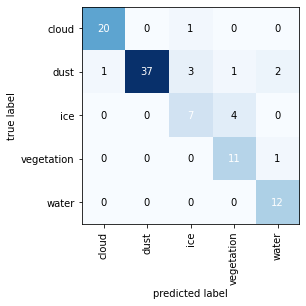

In [40]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

In [41]:
compute_accuracy(model=model, data_loader=test_loader, device=torch.device('cpu'))

tensor(87.)

In [ ]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader))) 

##### Changing the folder to data to get access of the .hdf file
This file is downloaded before from NASA LAADS DAAC. Changing the directory should be executed only once otherwise it will show error because it has already changed the directory.


In [ ]:
# Set working directory to data to get access of the file
# os.chdir(os.path.join(os.getcwd(), 'data'))

# Accessing file for processing
filename = os.path.join("MOD021KM.A2021092.0020.006.2021092134055.hdf")
filenames = [filename]

##### Loading data to scene object from SatPy. 
SatPy is used here for processing remote sensing images
Printing available dataset names which is required for listing the bands
Here total 36 bands information are available

In [ ]:
# MODIS scene object using the file retrieved from data folder
modis_scene = Scene(reader='modis_l1b', filenames=filenames)
modis_scene.available_dataset_names()
# modis_scene.unload

##### Method: Band Details and Plotting
This is the custom method which takes band no and color map as parameter and shows all the necessary information about that particular band. The second method plot_band() takes the band no as parameter and plot the band.

In [ ]:
def band_details(band_no, cmap):
    
    print("Band no: ", band_no)
    print("Platform name: ", modis_scene[band_no].attrs['platform_name'])
    print("Dimension: ", modis_scene[band_no].dims)
    print("No of dimension: ", modis_scene[band_no].ndim)
    print("Wavelength: ", modis_scene[band_no].wavelength)
    print("Calibration: ", modis_scene[band_no].calibration)
    print("Maximum value: ", modis_scene[band_no].max().values)
    
    modis_scene[band_no].plot.imshow(cmap=cmap)
    plt.title("Band-{}".format(band_no))

def plot_band(band_no):

    plt.figure()
    modis_scene.load([band_no])
    band_details(band_no, 'cividis')
    modis_scene[band_no]

In [ ]:
band_no = '3'
plot_band(band_no)

### Data Extraction
Image data is extrcted from the metadata of MODIS hdf file

In [ ]:
data = modis_scene[band_no]
data

### Resizing Image
The dimension of input image is too high so the reduced dimension of image is used by resizing it to (128, 128) where original image dimension was (2030, 1354). Finally image value is normalized by dividing by 255. Image is first converted to matrix and then again to numpy array to match the dimension.

In [ ]:
iteration = 100

image = resize(img_to_array(modis_scene[band_no]), (128, 128),  mode = 'constant', preserve_range = True)
image = image/255.0
image.shape
image = np.matrix(image)
image = np.array(image)
image


In [ ]:
# Plotting the image after resizing
plt.figure()
plt.imshow(image, cmap = 'viridis')
plt.title('Band - ' + band_no)

In [ ]:
modis_scene.unload